In [2]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from scipy.ndimage import measurements

In [3]:
# Different approach needed for this one as no obvious end point.
# Looks to have worked well. 

url='https://www.janestreet.com/puzzles/remote-sudoku/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:22]))

Fill each cell — even the ones with grey numbers — with a digit between 1 and 9 so that each row, column, and outlined 3-by-3 squares contains each digit once. A grey number N indicates that there is an N exactly N squares away (horizontally or vertically). The answer to this month’s puzzle is the sum of the squares of the numbers written over the gray numbers in the completed grid. (For example, if a 7 is written over one of the grey numbers, that would contribute 49 towards the sum.) © Copyright 2015-2021 Jane Street Group, LLC. All rights reserved. Services are provided in the U.S. by Jane Street Capital, LLC and Jane Street Execution Services, LLC, each of which is a SEC-registered broker dealer and member of FINRA (www.finra.org). Services are provided in Europe by Jane Street Financial Limited, a registered dealer authorized and regulated by the U.K. Financial Conduct Authority, and in Hong Kong by Jane Street Hong Kong Limited, a regulated entity under the Hong Kong Securities a

### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/04/20190401_remote_sudoku.png" width="350">

In [4]:
# Setup the constraints
fixed = np.array([[2, 0, 0, 0, 7, 1, 8, 3, 6],
                  [0, 0, 0, 0, 0, 0, 0, 2, 0],
                  [0, 0, 5, 0, 0, 5, 4, 0, 2],
                  [0, 0, 0, 1, 0, 0, 5, 0, 1],
                  [8, 3, 3, 0, 1, 0, 2, 4, 4],
                  [3, 0, 4, 0, 0, 3, 0, 0, 0],
                  [6, 0, 2, 3, 0, 0, 5, 0, 0],
                  [0, 4, 0, 0, 0, 0, 0, 0, 0],
                  [7, 2, 7, 3, 1, 0, 0, 0, 3]],dtype=int)

In [102]:
class Matrix():
    def __init__(self,fixed,filled = np.zeros((9,9))):
        self.fixed = fixed
        self.filled = filled
        x= np.ones((3,3))
        self.groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])
  
    ################################################
    # 
    

  
   
    ##############################################
    # Two last functions
    # From the solved grid get the score  
    # Loop through and print the grids
    def score(self):
        return  np.sum((self.filled[self.fixed>0]**2))
    
    def sol_print(self):      
        fig,ax = plt.subplots(1,1,figsize=(3,3))
        count = 0
        y = (self.fixed > 0) + self.groups*2
        ax = sns.heatmap(y,annot=self.filled,cbar=False,cmap="tab20",fmt="",vmin=0,vmax=19,linewidths=1,)
        ax.axis("off")
        plt.tight_layout()
   
                         
    ###############################################
    # Main solver.  
    def solve(self):
        start = time.perf_counter()
        stop = time.perf_counter()
        print("***Solved in {:.4f} seconds***".format(stop - start))
        print("The sum of the squares of the numbers  is {:,.0f}".format(self.score()))
        print("\nSolved Grid")
        print("~~~~~~~~~~~~")
        self.sol_print()
        

***Solved in 0.0000 seconds***
The sum of the squares of the numbers  is 1,105

Solved Grid
~~~~~~~~~~~~


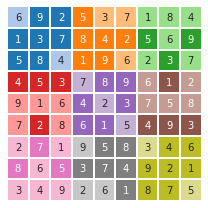

In [103]:
test = Matrix(fixed,filled)
test.solve()

In [73]:
url='https://www.janestreet.com/puzzles/solutions/april-2019-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The completed grid is shown to the left. The sum of the squares of the numbers written over the gray clues is 1105 . Congrats to this month’s solvers!


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/05/20190430_remote_sudoku_ans.png" width="300" >

In [12]:
filled = np.array([[6, 9, 2, 5, 3, 7, 1, 8, 4],
                  [1, 3, 7, 8, 4, 2, 5, 6, 9],
                  [5, 8, 4, 1, 9, 6, 2, 3, 7],
                  [4, 5, 3, 7, 8, 9, 6, 1, 2],
                  [9, 1, 6, 4, 2, 3, 7, 5, 8],
                  [7, 2, 8, 6, 1, 5, 4, 9, 3],
                  [2, 7, 1, 9, 5, 8, 3, 4, 6],
                  [8, 6, 5, 3, 7, 4, 9, 2, 1],
                  [3, 4, 9, 2, 6, 1, 8, 7, 5]],dtype=int)